In [1]:
# Cellule 2 - Imports
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.data_loader import load_stock_data, split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.partial_cointegration import PartialCointegrationModel
from strategies.partial_cointegration_trading import PartialCointegrationTrader
from utils.visualization import plot_cointegration_trade

In [2]:
data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)


Chargement des données à partir de data\jse_stocks.csv...
(6486, 51)


In [3]:
try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Informations sectorielles chargées pour 51 actions


In [4]:
train_data, test_data = split_data(prices, train_ratio=0.7)
print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data, significance_level=0.01)

print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées sur toute la période disponible")



Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 24 paires co-intégrées sur toute la période disponible



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 2: APN.JO - RDF.JO (p-value: 0.000010)
  Secteurs: APN.JO (Healthcare), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 3: WHL.JO - RDF.JO (p-value: 0.000017)
  Secteurs: WHL.JO (Industrials), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 4: AVI.JO - RDF.JO (p-value: 0.000027)
  Secteurs: AVI.JO (Industrials), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 5: FSR.JO - SLM.JO (p-value: 0.000058)
  Secteurs: FSR.JO (Financials), SLM.JO (Financials)
  Même secteur: Oui


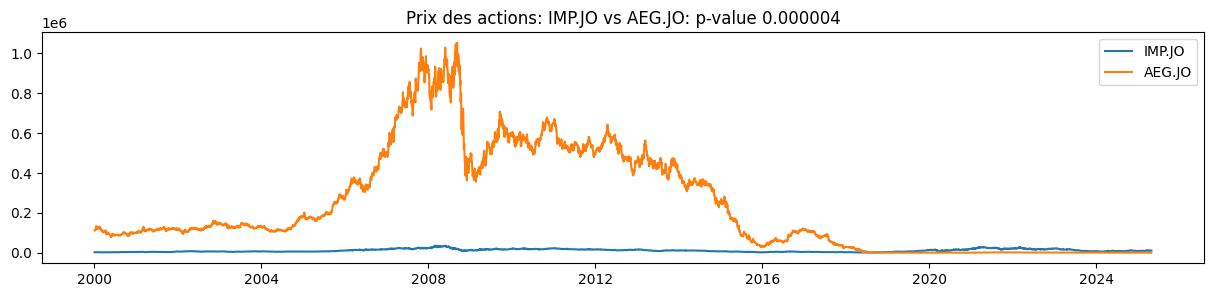

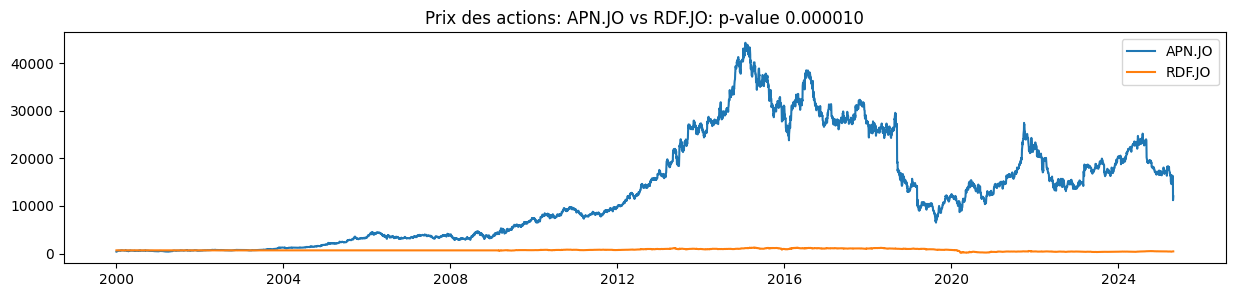

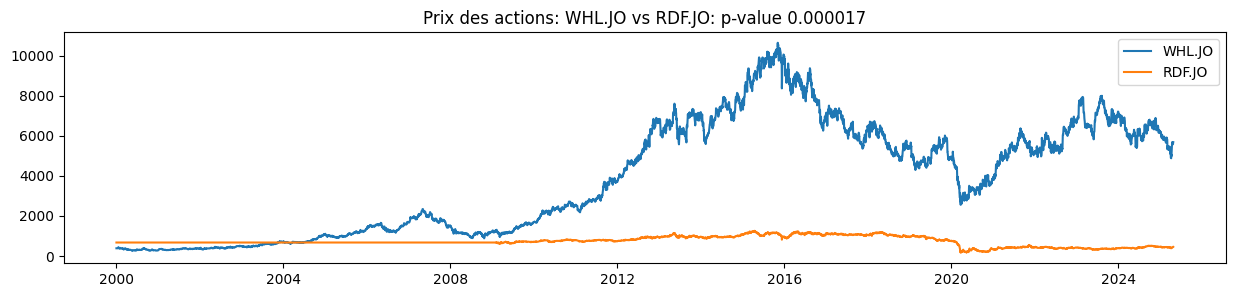

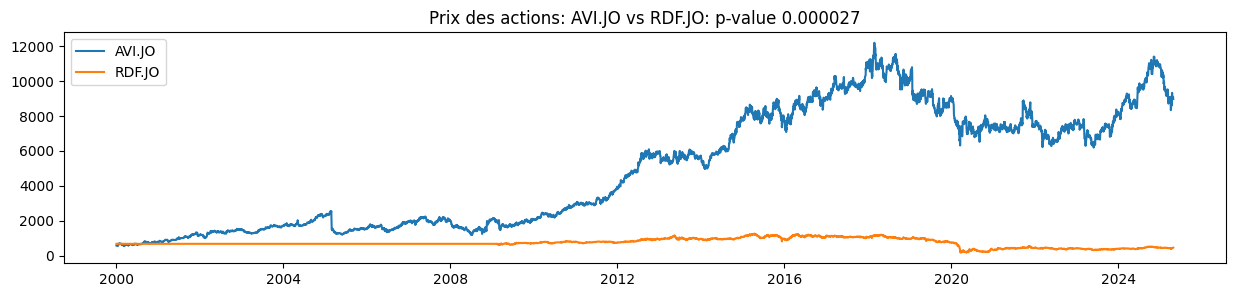

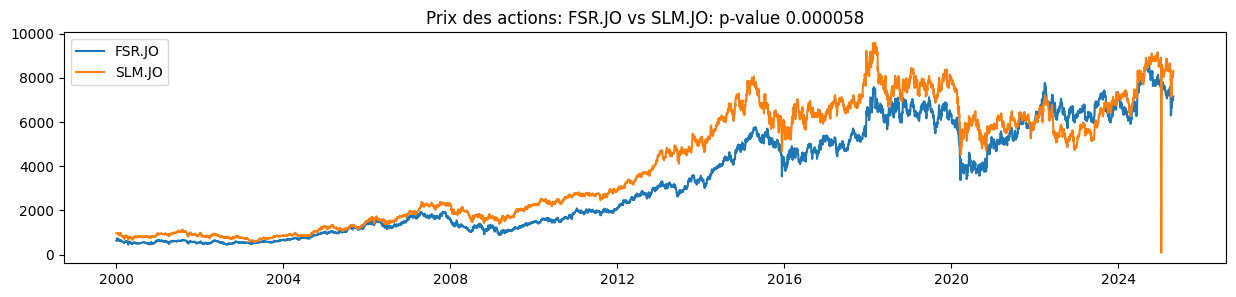

In [5]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(prices[ticker1], label=ticker1)
    plt.plot(prices[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 13058.7531, Sharpe: 0.9865, Trades: 134


ValueError: x and y must be the same size

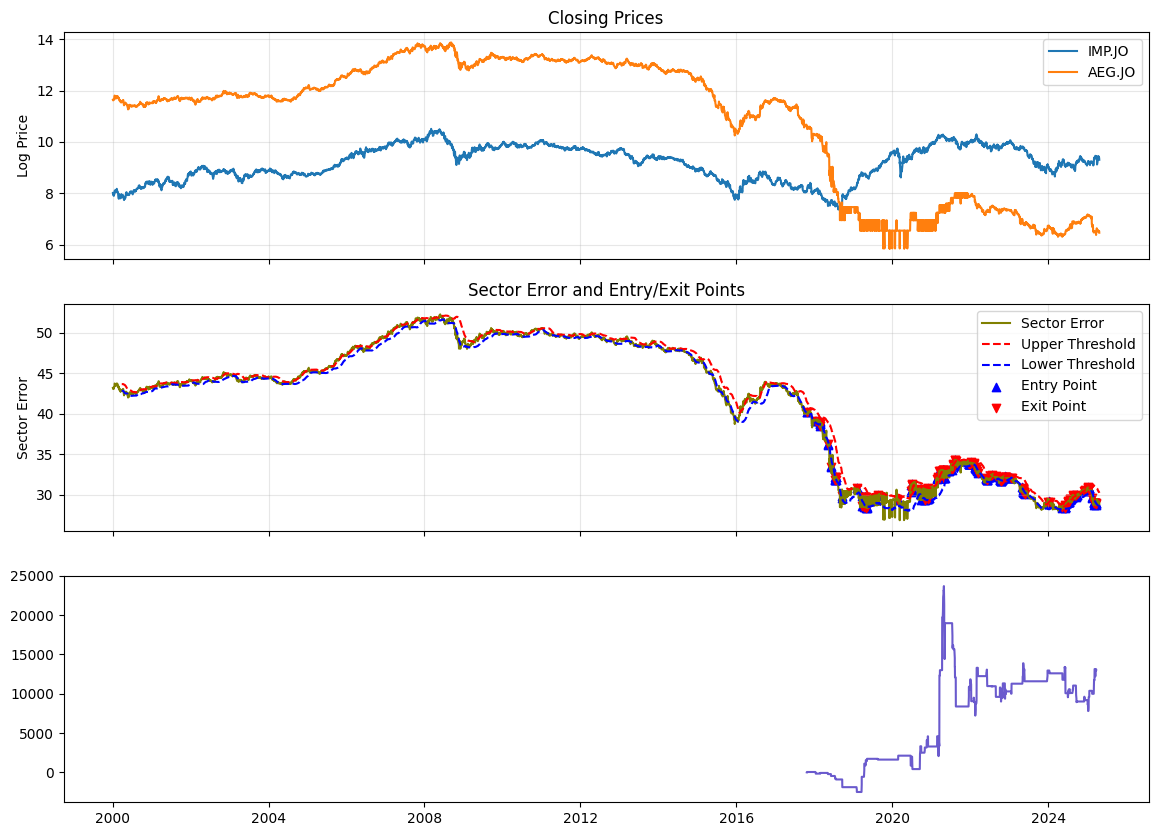

In [6]:
for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    model = PartialCointegrationModel(significance_level=0.05)

    trader = PartialCointegrationTrader(
        model,
        entry_threshold=1.25,  # Valeur optimale selon le document
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=60,
        kalman_gain=0.7  # Valeur optimale selon le document
    )

    trades = trader.run_backtest(
        test_data[ticker1], test_data[ticker2]
    )

    if trades.empty:
        print("    Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trader.trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values
    sharpe = (
        np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
        if len(pnl_values) >= 2 and np.std(pnl_values) > 0
        else 0
    )

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Rho": model.rho,  # Spécifique à la cointégration partielle
            "Kalman_Gain": model.kalman_gain,  # Spécifique à la cointégration partielle
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    
    plot_cointegration_trade(
        prices=prices,
        ticker1=ticker1,
        ticker2=ticker2,
        trades=trades,
        beta=model.beta,
        entry_threshold=1.25  # Valeur optimale pour la cointégration partielle
    )


In [8]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    model = PartialCointegrationModel(significance_level=0.05)
    trader = PartialCointegrationTrader(
        model,
        entry_threshold=1.25,
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=60,
        kalman_gain=0.7
    )

    trades = trader.run_backtest(
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")


    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Rho": model.rho,
            "Kalman_Gain": model.kalman_gain,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )


Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Performance: Rendement total: 13058.7531, Sharpe: 0.9865, Trades: 402

Analyse de la paire 2: APN.JO - RDF.JO (p-value: 0.000010)
  Performance: Rendement total: 10782.7706, Sharpe: 1.1483, Trades: 564

Analyse de la paire 3: WHL.JO - RDF.JO (p-value: 0.000017)
  Performance: Rendement total: 655.6796, Sharpe: 0.3441, Trades: 405

Analyse de la paire 4: AVI.JO - RDF.JO (p-value: 0.000027)
  Performance: Rendement total: -1389.8642, Sharpe: -0.5407, Trades: 583

Analyse de la paire 5: FSR.JO - SLM.JO (p-value: 0.000058)
  Performance: Rendement total: 15914.0719, Sharpe: 1.8739, Trades: 420

Analyse de la paire 6: MRP.JO - RDF.JO (p-value: 0.000061)
  Performance: Rendement total: -5390.2082, Sharpe: -0.6765, Trades: 459

Analyse de la paire 7: RMH.JO - RDF.JO (p-value: 0.000098)
  Performance: Rendement total: 55.8426, Sharpe: 1.6703, Trades: 300

Analyse de la paire 8: DSY.JO - RDF.JO (p-value: 0.000117)
  Performance: Rend

In [9]:
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Rendement total de toutes les paires: -524505.8796
Rendement moyen de toutes les paires: -39.9317
